# Importing relevant libraries 

In [1]:
import os
import dgl
import dgl.function as fn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
sns.set()
os.environ["DGLBACKEND"] = "pytorch"

# Adding cuda to the path 

In [2]:
os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\extras\CUPTI\lib64")
os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\bin")
os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\libnvvp")
os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\include")
os.add_dll_directory(r"C:\Users\siddh\CuDNN\cudnn-windows-x86_64-8.9.1.23_cuda11-archive\bin")

<AddedDllDirectory('C:\\Users\\siddh\\CuDNN\\cudnn-windows-x86_64-8.9.1.23_cuda11-archive\\bin')>

In [3]:
torch.cuda.is_available()

True

# Importing dataset from csv file into pandas DataFrame

In [4]:
df = pd.read_csv(r"C:\Users\siddh\Tensorflow_course\card_transaction.v1.csv").sample(n=100000,random_state=42)

In [5]:
df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
18199893,1470,0,2019,7,10,00:11,$59.18,Chip Transaction,-6853385250336487907,Harwood,MD,20776.0,5813,NaN,No
9731325,822,1,2019,1,14,22:12,$280.91,Online Transaction,4241336128694185533,ONLINE,NaN,NaN,4814,NaN,No
536687,41,3,2010,3,15,07:07,$-144.00,Swipe Transaction,190253443608377572,Hemet,CA,92543.0,3359,NaN,No
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
17070521,1384,0,2014,10,12,11:44,$9.17,Swipe Transaction,-5023497618971072366,Gardner,KS,66030.0,5812,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028639,254,3,2018,6,8,20:37,$23.90,Swipe Transaction,-3739862438923451178,Seguin,TX,78155.0,7832,NaN,No
11275290,937,1,2018,10,27,14:12,$24.23,Swipe Transaction,6661973303171003879,Fresno,CA,93723.0,5211,NaN,No
1327632,107,1,2008,4,17,11:15,$32.20,Swipe Transaction,7517466159504402752,Chicago,IL,60616.0,4900,NaN,No
2929345,243,2,2017,3,30,09:51,$2.54,Chip Transaction,-7573333216691584899,Pensacola,FL,32507.0,5812,NaN,No


# Data preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18199893 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            100000 non-null  int64  
 1   Card            100000 non-null  int64  
 2   Year            100000 non-null  int64  
 3   Month           100000 non-null  int64  
 4   Day             100000 non-null  int64  
 5   Time            100000 non-null  object 
 6   Amount          100000 non-null  object 
 7   Use Chip        100000 non-null  object 
 8   Merchant Name   100000 non-null  int64  
 9   Merchant City   100000 non-null  object 
 10  Merchant State  88782 non-null   object 
 11  Zip             88134 non-null   float64
 12  MCC             100000 non-null  int64  
 13  Errors?         1576 non-null    object 
 14  Is Fraud?       100000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 12.2+ MB


In [7]:
df.iloc[:,-1].value_counts()

No     99883
Yes      117
Name: Is Fraud?, dtype: int64

In [8]:
# Since the data in 'Is Fraud?' column is highly skewed towards "No" I tried to balance it a bit
df.drop(df.index[[i for i in range(99116) if df["Is Fraud?"].iloc[i] == "No"]], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4095350 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User            1000 non-null   int64  
 1   Card            1000 non-null   int64  
 2   Year            1000 non-null   int64  
 3   Month           1000 non-null   int64  
 4   Day             1000 non-null   int64  
 5   Time            1000 non-null   object 
 6   Amount          1000 non-null   object 
 7   Use Chip        1000 non-null   object 
 8   Merchant Name   1000 non-null   int64  
 9   Merchant City   1000 non-null   object 
 10  Merchant State  826 non-null    object 
 11  Zip             799 non-null    float64
 12  MCC             1000 non-null   int64  
 13  Errors?         18 non-null     object 
 14  Is Fraud?       1000 non-null   object 
dtypes: float64(1), int64(7), object(7)
memory usage: 125.0+ KB


In [10]:
df.iloc[:,-1].value_counts()

No     883
Yes    117
Name: Is Fraud?, dtype: int64

Now the "No" to "Yes" ratio looks pretty reasonalbe to train our model on

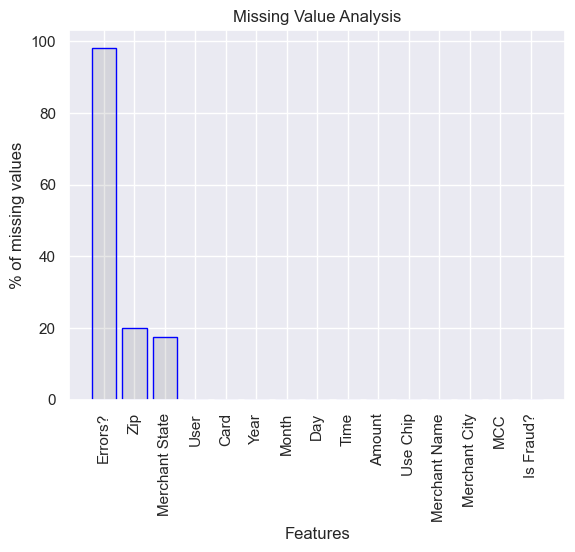

In [11]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90);

In [12]:
# fill the empty cells of 'Errors?' columns as "No Error"
df["Errors?"]= df["Errors?"].fillna("No error")

In [13]:
df["Errors?"].unique()

array(['No error', 'Bad PIN,', 'Insufficient Balance,',
       'Bad Card Number,Insufficient Balance,', 'Bad Zipcode,'],
      dtype=object)

In [14]:
# Created a new feature "card_id" using "User" and "Card"
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [15]:
# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

C:\Users\siddh\AppData\Local\Temp\ipykernel_27592\206150659.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["Amount"]=df["Amount"].str.replace("$","").astype(float)


In [16]:
# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [17]:
df.Hour

4095350     11
21181609    15
12477227    10
15267585    12
10517174    09
            ..
3028639     20
11275290    14
1327632     11
2929345     09
4816941     11
Name: Hour, Length: 1000, dtype: object

In [18]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4095350 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            1000 non-null   int64  
 1   Month           1000 non-null   int64  
 2   Day             1000 non-null   int64  
 3   Amount          1000 non-null   float64
 4   Use Chip        1000 non-null   object 
 5   Merchant Name   1000 non-null   int64  
 6   Merchant City   1000 non-null   object 
 7   Merchant State  826 non-null    object 
 8   Zip             799 non-null    float64
 9   MCC             1000 non-null   int64  
 10  Errors?         1000 non-null   object 
 11  Is Fraud?       1000 non-null   object 
 12  card_id         1000 non-null   object 
 13  Hour            1000 non-null   object 
 14  Minute          1000 non-null   object 
dtypes: float64(2), int64(5), object(8)
memory usage: 125.0+ KB


In [19]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [20]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [21]:
df["Errors?"].unique()

array([4, 1, 3, 0, 2])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4095350 to 4816941
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           1000 non-null   int64  
 1   Month          1000 non-null   int64  
 2   Day            1000 non-null   int64  
 3   Amount         1000 non-null   float64
 4   Use Chip       1000 non-null   int32  
 5   Merchant Name  1000 non-null   int64  
 6   Merchant City  1000 non-null   int32  
 7   MCC            1000 non-null   int64  
 8   Errors?        1000 non-null   int32  
 9   Is Fraud?      1000 non-null   int64  
 10  card_id        1000 non-null   object 
 11  Hour           1000 non-null   object 
 12  Minute         1000 non-null   object 
dtypes: float64(1), int32(3), int64(6), object(3)
memory usage: 97.7+ KB


In [23]:
# Create a normalized Merchant Name column
max_merchant = max(df["Merchant Name"])
max_merchant

9165734724105791716

In [24]:
df["Merchant Name Normed"] = df["Merchant Name"]/max_merchant

In [25]:
df.drop(columns=["Merchant Name"], axis = 1)

,Year,Month,Day,Amount,Use Chip,Merchant City,MCC,Errors?,Is Fraud?,card_id,Hour,Minute,Merchant Name Normed
4095350,2018,6,4,2.86,2,425,5310,4,1,333_4,11,39,0.660219
21181609,2018,8,2,0.96,2,425,5712,4,1,1727_2,15,13,-0.430261
12477227,2016,5,24,71.18,1,0,5311,4,1,1025_1,10,08,-0.809656
15267585,2010,3,2,89.59,2,402,5310,4,1,1248_1,12,25,0.698750
10517174,2012,4,12,81.61,1,0,4829,4,1,881_0,09,45,-0.467226
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028639,2018,6,8,23.90,2,453,7832,4,0,254_3,20,37,-0.408026
11275290,2018,10,27,24.23,2,184,5211,4,0,937_1,14,12,0.726835
1327632,2008,4,17,32.20,2,92,4900,4,0,107_1,11,15,0.820171
2929345,2017,3,30,2.54,0,388,5812,4,0,243_2,09,51,-0.826266


In [26]:
df["card_id"] = df["card_id"].astype("float64")

In [27]:
df.iloc[:,:] = df.iloc[:,:].astype("float64")

C:\Users\siddh\AppData\Local\Temp\ipykernel_27592\1413969531.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,:] = df.iloc[:,:].astype("float64")


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4095350 to 4816941
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  1000 non-null   float64
 1   Month                 1000 non-null   float64
 2   Day                   1000 non-null   float64
 3   Amount                1000 non-null   float64
 4   Use Chip              1000 non-null   float64
 5   Merchant Name         1000 non-null   float64
 6   Merchant City         1000 non-null   float64
 7   MCC                   1000 non-null   float64
 8   Errors?               1000 non-null   float64
 9   Is Fraud?             1000 non-null   float64
 10  card_id               1000 non-null   float64
 11  Hour                  1000 non-null   float64
 12  Minute                1000 non-null   float64
 13  Merchant Name Normed  1000 non-null   float64
dtypes: float64(14)
memory usage: 117.2 KB


In [29]:
# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

In [30]:
df

,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,MCC,Errors?,Is Fraud?,card_id,Hour,Minute,Merchant Name Normed
0,2015.0,3.0,21.0,100.00,0.0,-4.282467e+18,353.0,4829.0,4.0,0.0,9100.0,21.0,22.0,-0.467226
1,2015.0,11.0,21.0,8.48,0.0,4.751696e+18,186.0,5814.0,4.0,0.0,9101.0,8.0,58.0,0.518420
2,2004.0,9.0,3.0,37.44,2.0,8.851751e+18,57.0,5310.0,4.0,0.0,9141.0,4.0,47.0,0.965744
3,2013.0,7.0,24.0,20.04,2.0,5.291583e+18,147.0,5813.0,4.0,0.0,5661.0,16.0,21.0,0.577322
4,2013.0,5.0,24.0,26.11,2.0,-4.317138e+18,343.0,5211.0,4.0,0.0,10690.0,17.0,27.0,-0.471008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019.0,7.0,29.0,60.46,0.0,-5.652550e+18,13.0,5812.0,4.0,0.0,13611.0,22.0,42.0,-0.616704
996,2015.0,6.0,5.0,23.77,2.0,-2.451783e+17,306.0,5311.0,4.0,0.0,17550.0,11.0,9.0,-0.026749
997,2010.0,3.0,28.0,171.48,1.0,4.943697e+18,0.0,5816.0,4.0,1.0,11221.0,7.0,51.0,0.539367
998,2007.0,10.0,31.0,17.78,2.0,-8.649214e+18,348.0,5812.0,4.0,0.0,2600.0,21.0,12.0,-0.943647


In [31]:
df = df.drop(columns=['Merchant Name'])

In [32]:
df.describe()

,Year,Month,Day,Amount,Use Chip,Merchant City,MCC,Errors?,Is Fraud?,card_id,Hour,Minute,Merchant Name Normed
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,2012.212000,6.625000,16.111000,45.246160,1.304000,232.248000,5526.522000,3.968000,0.117000,10106.72200,12.014000,29.856000,-0.019831
std,5.050997,3.461265,8.877133,83.044199,0.856924,178.516432,861.885736,0.273954,0.321581,5621.69926,5.171513,16.938246,0.528742
min,1992.000000,1.000000,1.000000,-483.000000,0.000000,0.000000,3006.000000,0.000000,0.000000,21.00000,0.000000,0.000000,-0.998222
25%,2009.000000,4.000000,9.000000,9.622500,0.000000,53.750000,5300.000000,4.000000,0.000000,5357.75000,8.000000,15.000000,-0.467226
50%,2013.000000,7.000000,16.000000,29.510000,2.000000,228.000000,5499.000000,4.000000,0.000000,10196.00000,12.000000,30.000000,-0.031353
75%,2016.000000,10.000000,24.000000,68.792500,2.000000,388.250000,5812.000000,4.000000,0.000000,14784.75000,16.000000,44.000000,0.445614
max,2020.000000,12.000000,31.000000,790.420000,2.000000,554.000000,9402.000000,4.000000,1.000000,19971.00000,23.000000,59.000000,1.000000


# Data Vizualizations

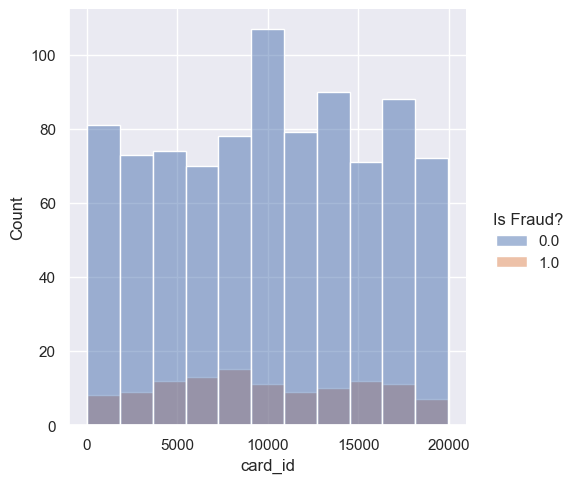

In [33]:
sns.displot(df,x="card_id", hue="Is Fraud?", kind='hist');

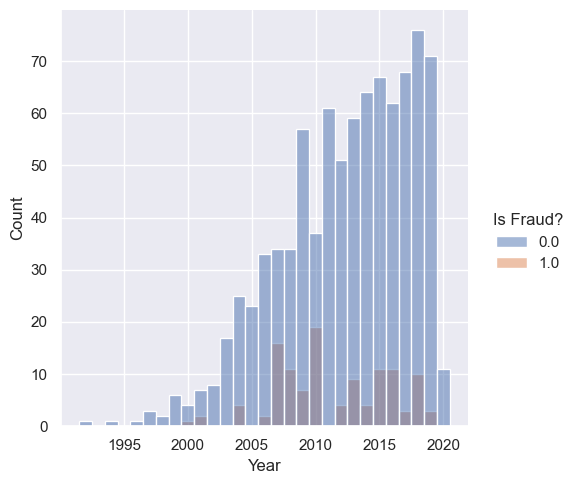

In [34]:
sns.displot(df, x="Year", hue="Is Fraud?",kind = "hist", discrete=True);

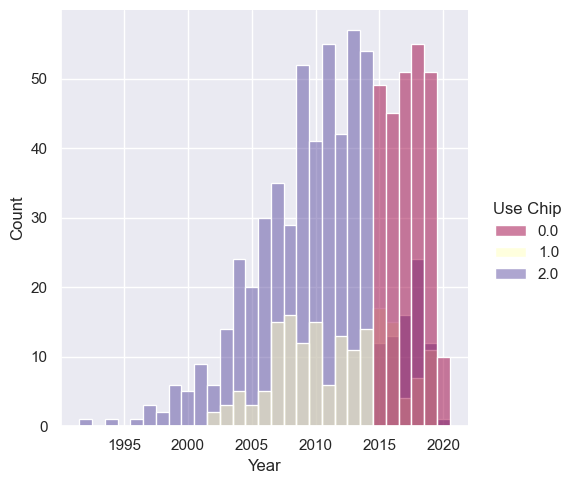

In [35]:
sns.displot(df, x="Year", hue="Use Chip",kind = "hist", discrete=True,palette="Spectral");

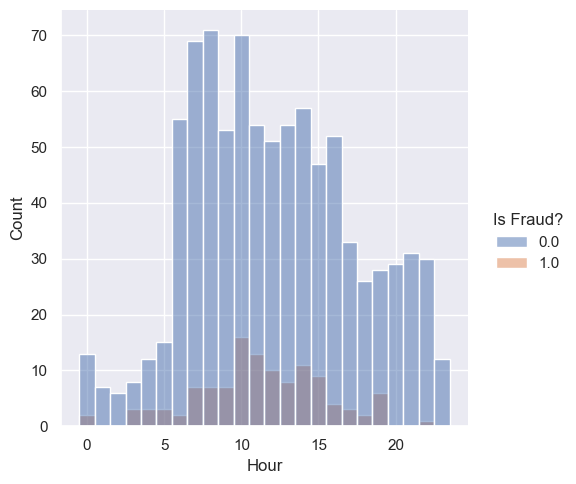

In [36]:
sns.displot(df, x="Hour", hue="Is Fraud?",kind = "hist", discrete=True);

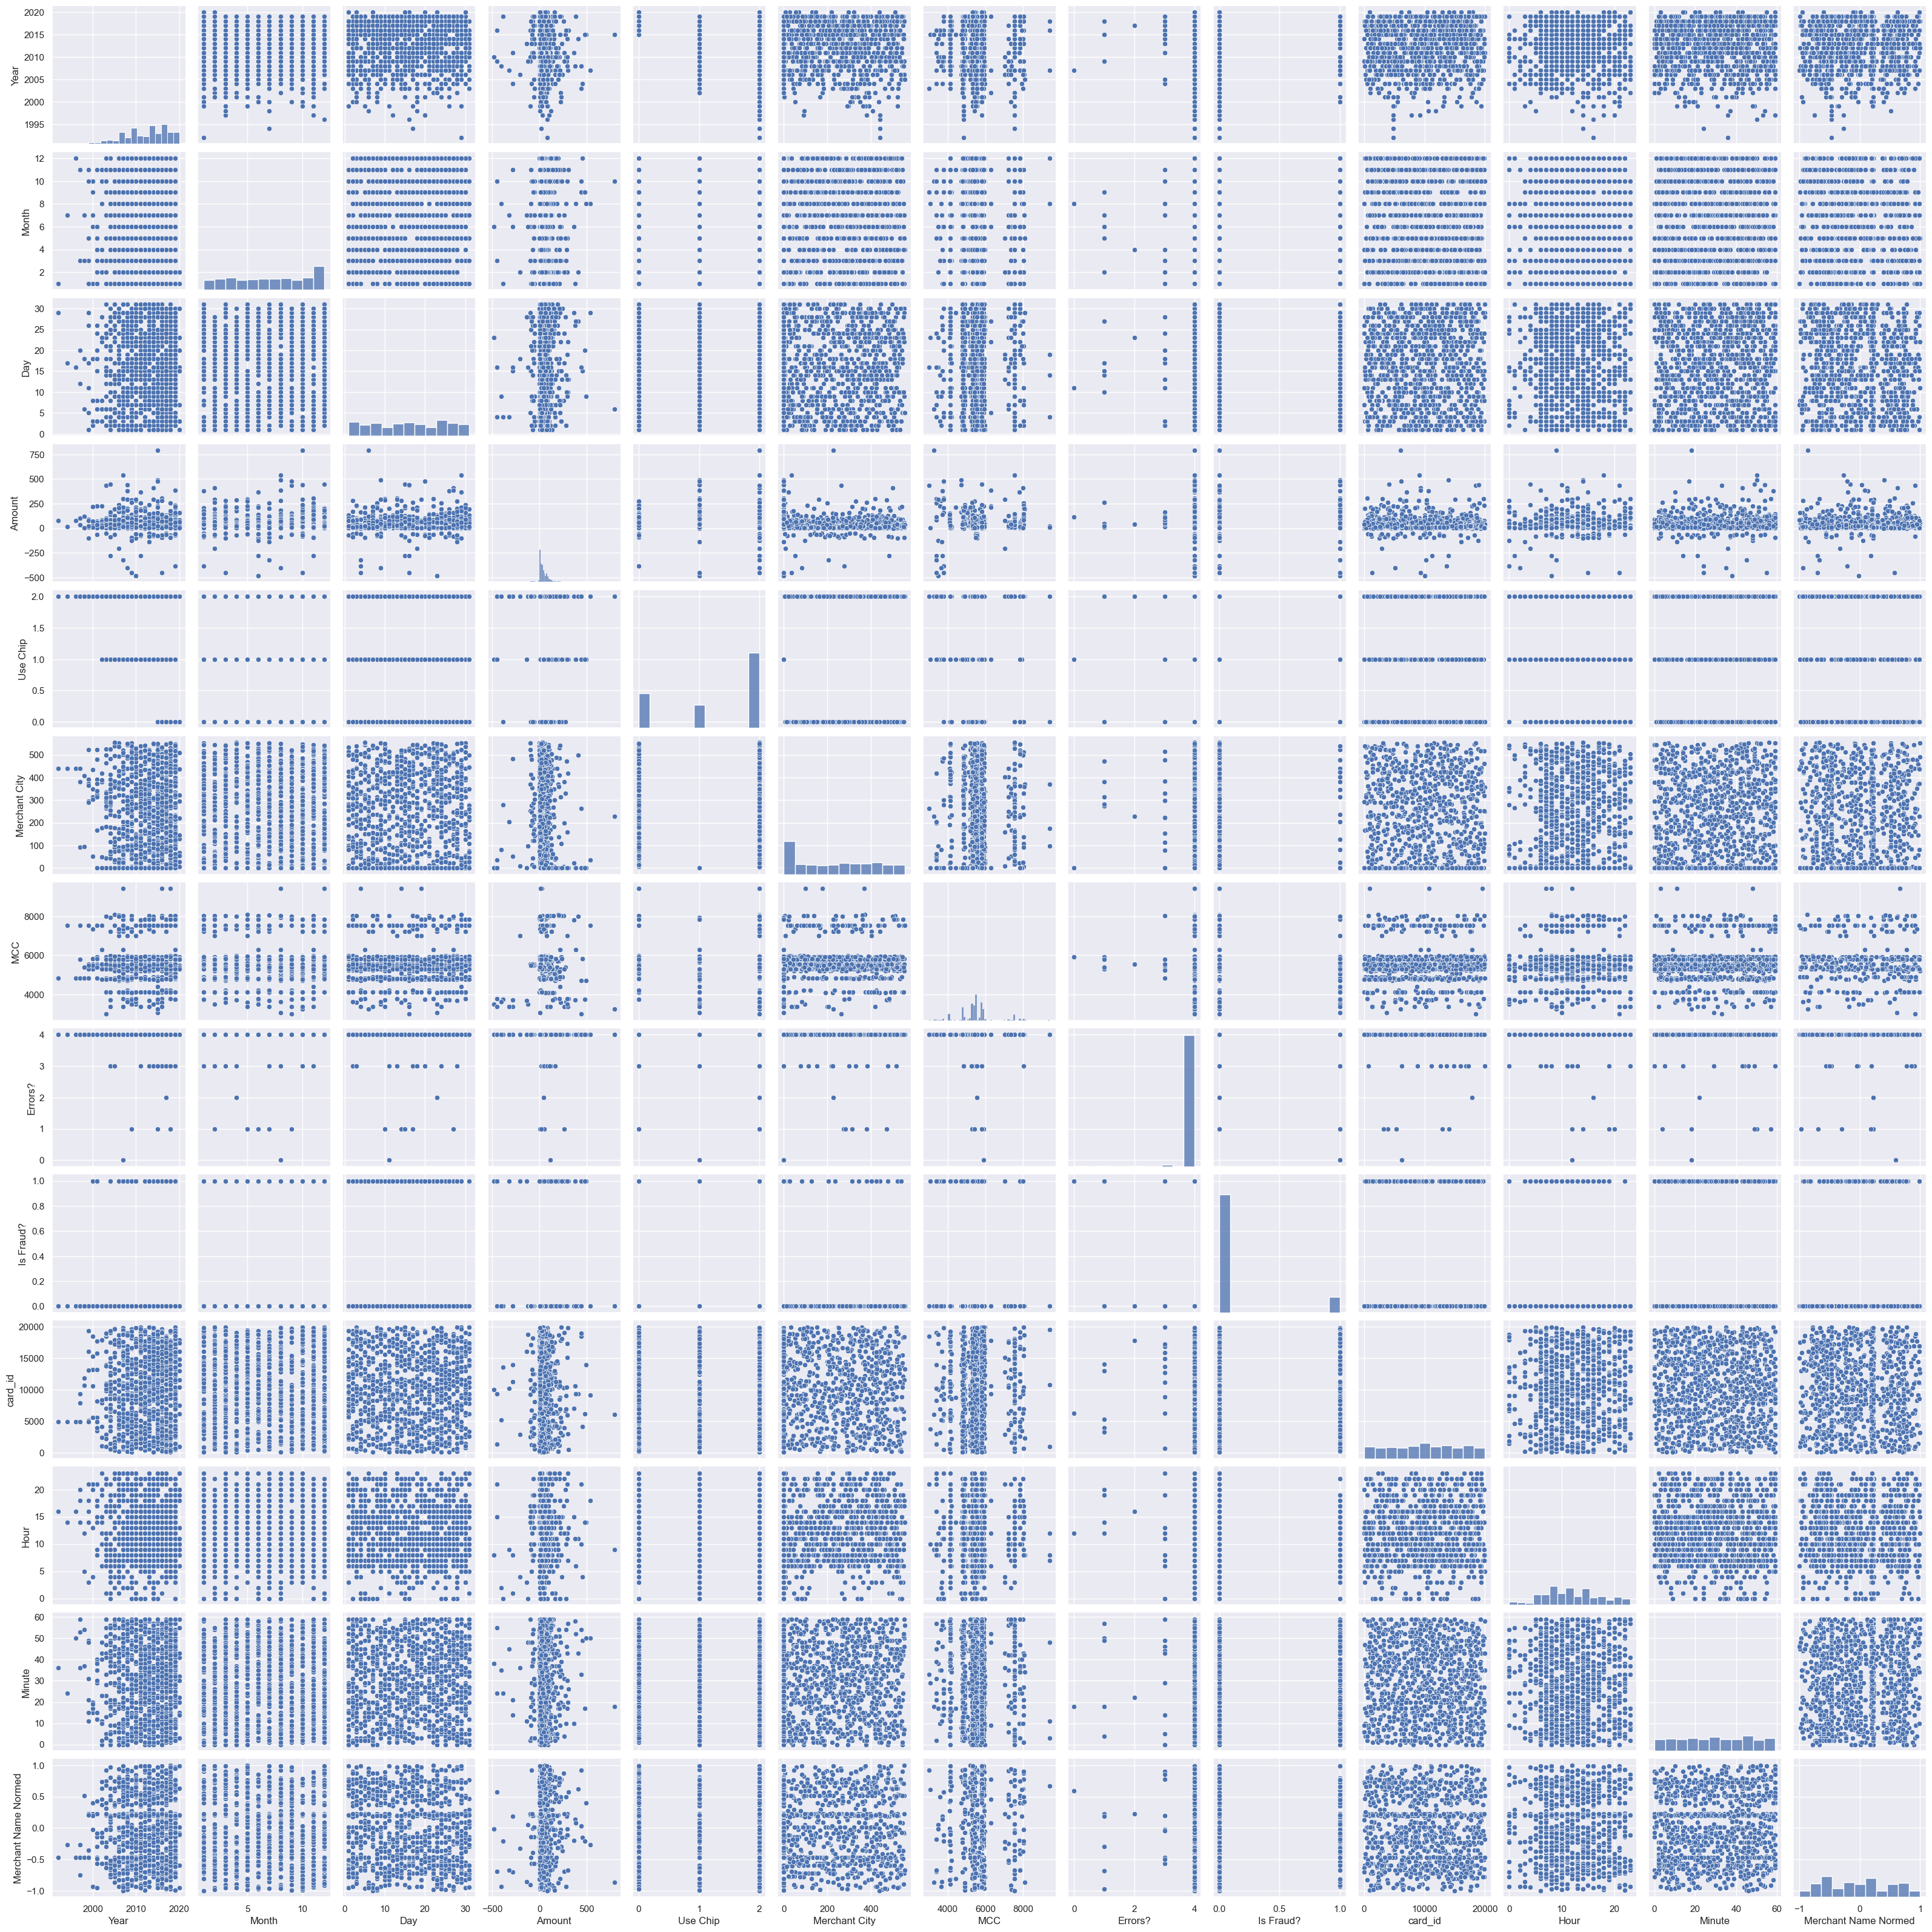

In [37]:
sns.pairplot(df)

In [38]:
df_Chip_Fraud = pd.DataFrame(df.groupby(['Use Chip','Is Fraud?'])['Use Chip'].count())
df_Chip_Fraud

Use Chip
Use Chip Is Fraud?          
0.0      0.0             248
         1.0              13
1.0      0.0              95
         1.0              79
2.0      0.0             540
         1.0              25

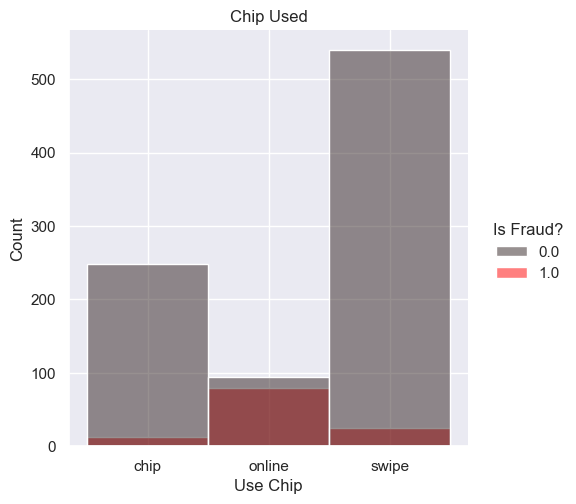

In [39]:
sns.displot(data=df,x="Use Chip",hue="Is Fraud?",bins=[0,1,2],discrete=True, palette='dark:red')
plt.xticks([0,1,2], ["chip","online","swipe"])
plt.title("Chip Used");

# CREATE GRAPH

In [64]:
GG = dgl.DGLGraph()

C:\Users\siddh\anaconda3\envs\tf_gpu\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [65]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.int64)

In [66]:
target

tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [67]:
df['Is Fraud?'].value_counts()

0.0    883
1.0    117
Name: Is Fraud?, dtype: int64

In [68]:
train_mask = []
for i in range(900):
    train_mask.append(True)
for i in range(100):
    train_mask.append(False)

In [69]:
train_mask = torch.tensor(train_mask)

In [70]:
val_mask = []
for i in range(900):
    val_mask.append(False)
for i in range(100):
    val_mask.append(True)

In [71]:
val_mask = torch.tensor(val_mask)

In [72]:
train_df = df.drop(columns=['Is Fraud?'])

In [73]:
train_x = train_df.to_numpy(dtype="float16")
train_x

array([[ 2.015e+03,  3.000e+00,  2.100e+01, ...,  2.100e+01,  2.200e+01,
        -4.673e-01],
       [ 2.015e+03,  1.100e+01,  2.100e+01, ...,  8.000e+00,  5.800e+01,
         5.186e-01],
       [ 2.004e+03,  9.000e+00,  3.000e+00, ...,  4.000e+00,  4.700e+01,
         9.658e-01],
       ...,
       [ 2.010e+03,  3.000e+00,  2.800e+01, ...,  7.000e+00,  5.100e+01,
         5.396e-01],
       [ 2.007e+03,  1.000e+01,  3.100e+01, ...,  2.100e+01,  1.200e+01,
        -9.438e-01],
       [ 1.998e+03,  7.000e+00,  1.800e+01, ...,  5.000e+00,  3.700e+01,
         5.151e-01]], dtype=float16)

In [74]:
GG.add_nodes(1000, {"feat" : torch.tensor(train_x,dtype=torch.float), 
                    "label" : target,
                    "train_mask" : train_mask,
                    "val_mask" : val_mask})

In [75]:
GG.ndata

{'feat': tensor([[ 2.0150e+03,  3.0000e+00,  2.1000e+01,  ...,  2.1000e+01,
          2.2000e+01, -4.6729e-01],
        [ 2.0150e+03,  1.1000e+01,  2.1000e+01,  ...,  8.0000e+00,
          5.8000e+01,  5.1855e-01],
        [ 2.0040e+03,  9.0000e+00,  3.0000e+00,  ...,  4.0000e+00,
          4.7000e+01,  9.6582e-01],
        ...,
        [ 2.0100e+03,  3.0000e+00,  2.8000e+01,  ...,  7.0000e+00,
          5.1000e+01,  5.3955e-01],
        [ 2.0070e+03,  1.0000e+01,  3.1000e+01,  ...,  2.1000e+01,
          1.2000e+01, -9.4385e-01],
        [ 1.9980e+03,  7.0000e+00,  1.8000e+01,  ...,  5.0000e+00,
          3.7000e+01,  5.1514e-01]]), 'label': tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 

In [84]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
# model = GCN(GG.ndata['feat'].shape[1], 4, 2)

In [85]:
def train(GG, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
    best_val_acc = 0
    best_test_acc = 0

    features = GG.ndata['feat']
    labels = GG.ndata['label']
    train_mask = GG.ndata['train_mask']
    val_mask = GG.ndata['val_mask']
    for e in range(75):
        # Forward
        logits = model(GG, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        print('In epoch {}   loss: {:.3f}    acc: {:.3f}    val acc: {:.3f} (best {:.3f})'.format(
            e, loss, train_acc, val_acc, best_val_acc))

# GG = GG.to('cuda')
gsl = dgl.add_self_loop(GG)
model = GCN(GG.ndata['feat'].shape[1],4,2)
train(gsl, model)

In epoch 0   loss: 1394.092    acc: 0.114    val acc: 0.140 (best 0.140)
In epoch 1   loss: 1046.708    acc: 0.114    val acc: 0.140 (best 0.140)
In epoch 2   loss: 699.653    acc: 0.120    val acc: 0.150 (best 0.150)
In epoch 3   loss: 360.740    acc: 0.173    val acc: 0.200 (best 0.200)
In epoch 4   loss: 85.659    acc: 0.502    val acc: 0.420 (best 0.420)
In epoch 5   loss: 33.367    acc: 0.870    val acc: 0.850 (best 0.850)
In epoch 6   loss: 64.151    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 7   loss: 93.275    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 8   loss: 117.611    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 9   loss: 137.837    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 10   loss: 154.526    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 11   loss: 168.134    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 12   loss: 179.026    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 13   loss: 187.508    acc: 0.886    val acc: 0.860 (be

In [86]:
import dgl.function as fn

class SAGEConv(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(SAGEConv, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g):
        g.ndata['h'] = h
        # update_all is a message passing API.
        g.update_all(message_func=fn.copy_u('h', 'm'), reduce_func=fn.mean('m', 'h_N'))            
        h_N = g.ndata['h_N']
        h_total = torch.cat([h, h_N], dim=1)
            
        return self.linear(h_total)

In [87]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [88]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
    all_logits = []
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    for e in range(75):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that we should only compute the losses of the nodes in the training set,
        # i.e. with train_mask 1.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())

        
        print('In epoch {}   loss: {:.3f}    acc: {:.3f}    val acc: {:.3f} (best {:.3f})'.format(
            e, loss, train_acc, val_acc, best_val_acc))

gsl = dgl.add_self_loop(GG)
model = GCN(GG.ndata['feat'].shape[1],16,2)
train(gsl, model)

In epoch 0   loss: 2806.726    acc: 0.114    val acc: 0.140 (best 0.140)
In epoch 1   loss: 2036.363    acc: 0.114    val acc: 0.140 (best 0.140)
In epoch 2   loss: 1283.553    acc: 0.114    val acc: 0.140 (best 0.140)
In epoch 3   loss: 550.635    acc: 0.140    val acc: 0.160 (best 0.160)
In epoch 4   loss: 78.984    acc: 0.652    val acc: 0.720 (best 0.720)
In epoch 5   loss: 107.793    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 6   loss: 171.928    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 7   loss: 224.315    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 8   loss: 267.271    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 9   loss: 302.340    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 10   loss: 330.570    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 11   loss: 352.912    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 12   loss: 370.106    acc: 0.886    val acc: 0.860 (best 0.860)
In epoch 13   loss: 382.706    acc: 0.886    val acc: 0.860